# Semantic Segmentation and Instance Segmentation Assignment

Run the next cell ONLY IF YOU ARE USING COLAB:

In [ ]:
!gdown --id 1wzAVGdHnNepfBBDpRO2EmHiqqFfxpOGp
!unzip colab.zip

# A) Warm-Up



There are different interpolation types to upsample an image, such as nearest, linear, bilinear, bicubic... In this question, an original size baboon image, and a downsampled baboon image is provided. Interpolate the downsampled image with different modes, visualize them.

Typically, PSNR and SSIM metrics are used to evaluate the quality of a compressed/decompressed image. We can use them to measure the interpolation quality. 


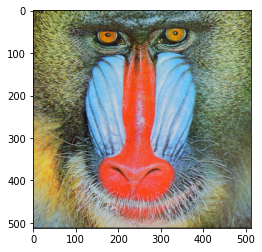

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline 

img = cv2.imread('baboon.jpg') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

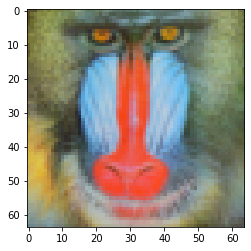

In [ ]:
from skimage import data, color, img_as_float
from skimage.transform import rescale, resize

img = img_as_float(img)
image_resized = resize(img, (img.shape[0] // 8, img.shape[1] // 8))

plt.imshow(image_resized)

In [ ]:
import torch
import torch.nn

img_tensor = torch.from_numpy(image_resized.transpose(2,0,1)).unsqueeze(0)

# TODO: Use interpolation function torch.nn.functional to upsample images with different modes.
img_nearest = torch.nn.functional.interpolate(img_tensor, img.shape[:-1], mode='nearest')
img_bilinear = torch.nn.functional.interpolate(img_tensor, img.shape[:-1], mode='bilinear')
img_bicubic = torch.nn.functional.interpolate(img_tensor, img.shape[:-1], mode='bicubic')

# TODO: Convert images back to numpy. 
img_nearest = img_nearest.squeeze(0).numpy().transpose(1, 2, 0)
img_bilinear = img_bilinear.squeeze(0).numpy().transpose(1, 2, 0)
img_bicubic = img_bicubic.squeeze(0).numpy().transpose(1, 2, 0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


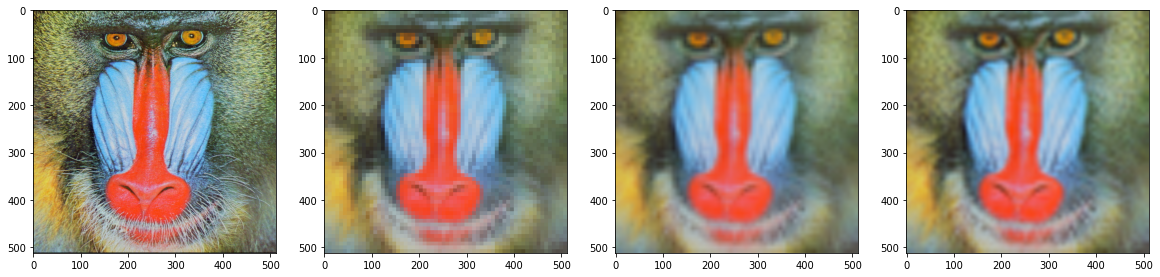

In [ ]:
# Visualization of images
f, axarr = plt.subplots(1,4,figsize=(20,20))
axarr[0].imshow(img)
axarr[1].imshow(img_nearest)
axarr[2].imshow(img_bilinear)
axarr[3].imshow(img_bicubic)

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# TODO: calculate the psnr and ssim scores between original image and upsampled
# version. Do these scores align with the visualizations?

print(ssim(img_nearest, img, multichannel=True), psnr(img_nearest, img))
print(ssim(img_bilinear, img, multichannel=True), psnr(img_bilinear, img))
print(ssim(img_bicubic, img, multichannel=True), psnr(img_bicubic, img))

0.43215310264632806 19.107352326992938
0.4444279513220459 19.217285842720976
0.45538129891363804 19.419787077134643


Answer: 

As shown in the visualization, we can see improvements from nearest to bicubic interpolations aligned with the SSIM and PSNR scores.

# B) Fully Convolutional Network for Semantic Segmentation

In this exercise, we will implement a neural network for semantic segmentation, and train and test the results with the provided dataset. As it would take a long time to train the whole network, we'll finetune the model by reusing a pretrained backbone model (eg. VGG16). You can influence from FCN, which is one of the first architectures proposed for semantic segmentation[1](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf). 

We provide a skeleton code which should be filled in respectively. The dataloaders and utilization codes are also provided. 

<img src="https://camo.githubusercontent.com/d10b897e15344334e449104a824aff6c29125dc2/687474703a2f2f63616c76696e2e696e662e65642e61632e756b2f77702d636f6e74656e742f75706c6f6164732f646174612f636f636f7374756666646174617365742f636f636f73747566662d6578616d706c65732e706e67">





## MSRC-v2 Segmentation Dataset


We'll use the MSRC dataset for this exercise, which contains 591 images and 23 different semantic labels. The training is done on 443 images, validation on 74 and testing on 74 images. More info about the labels can be found on "info.html". 

To get the dataset run the commands below to directly get them into the notebook.

In [ ]:
!wget http://download.microsoft.com/download/3/3/9/339D8A24-47D7-412F-A1E8-1A415BC48A15/msrc_objcategimagedatabase_v2.zip
!unzip msrc_objcategimagedatabase_v2.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from segmentation_nn import SegmentationNN
from data_utils import SegmentationData, label_img_to_rgb

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
train_data = SegmentationData(image_paths_file='segmentation_splits/train.txt')
val_data = SegmentationData(image_paths_file='segmentation_splits/val.txt')

Train size: 443
Validation size: 74
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


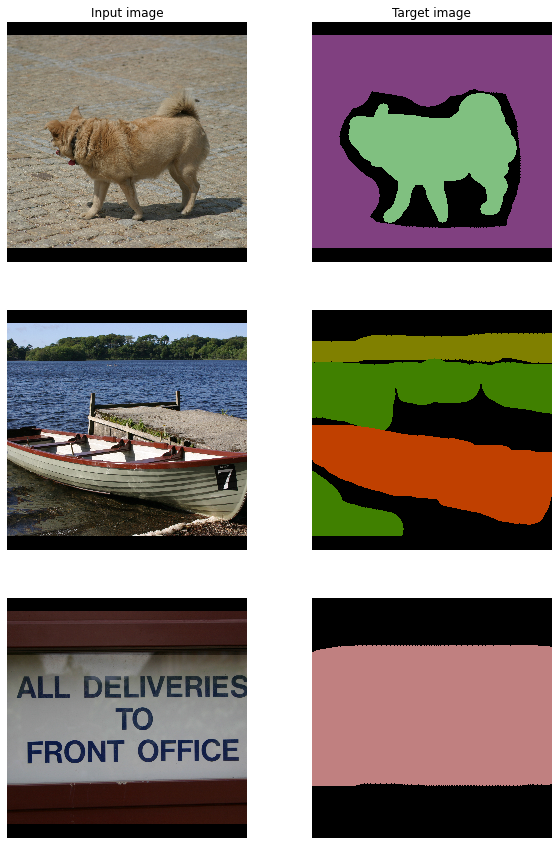

In [ ]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 3
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

## Part 1: Implement and Train the Network:

Let's implement the neural network by filling up the necessary parts in `segmentation_nn.py`. It will take an input of size (N, C, H, W) and output (N, num_classes, H, W). As a pretrained backbone, you can use the VGG16 network from torchvision library, or any other backbone you wish. Start with a simple model where you take the feature layer from VGG, and introduce several layers which end up with segmentation predictions (FCN32 might be an example).

For training, we provide the skeleton `solver.py` code. Fill in the given code for training and evaluation. The dataloaders are already provided, and you need to code up the stochastic gradient descent by using pytorch functions. As for the loss, we can go with the typical `CrossEntropyLoss`. Note that there are some `unlabeled` classes in the dataset. These pixels should not be considered in the loss nor in the accuracy of the segmentation.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

## This is provided for debugging! After implementing the network, put it into
## the "segmentation_nn.py" file. 

class FCN(nn.Module):

    def __init__(self, num_classes=23):
        super(FCN, self).__init__()

        model = models.vgg16(pretrained= True)

    def forward(self, x):
      pass

In [ ]:
from segmentation_nn import SegmentationNN
import torch.nn.functional as F


########################################################################
#                             YOUR CODE                                #
########################################################################
# Tip: You can freeze the backbone
# Tip: Try overfitting the network first, for a single sample.

from random import shuffle
import numpy as np

import torch
from torch.autograd import Variable


class Solver(object):
    default_adam_args = {"lr": 1e-4,
                         "betas": (0.9, 0.999),
                         "eps": 1e-8,
                         "weight_decay": 0.0}

    def __init__(self, optim=torch.optim.Adam, optim_args={},
                 loss_func=torch.nn.CrossEntropyLoss(ignore_index=-1)):
        optim_args_merged = self.default_adam_args.copy()
        optim_args_merged.update(optim_args)
        self.optim_args = optim_args_merged
        self.optim = optim
        self.loss_func = loss_func

        self._reset_histories()

    def _reset_histories(self):
        """
        Resets train and val histories for the accuracy and the loss.
        """
        self.train_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.val_loss_history = []

    def pixel_acc(self, pred, target):
        targets_mask = target >= 0
        acc = np.mean((pred == target)[targets_mask].data.cpu().numpy())
        return acc

    def train(self, model, train_loader, val_loader, batch_size=10, num_epochs=10, log_nth=10):
        """
        Train a given model with the provided data.

        Inputs:
        - model: model object initialized from a torch.nn.Module
        - train_loader: train data in torch.utils.data.DataLoader
        - val_loader: val data in torch.utils.data.DataLoader
        - num_epochs: total number of training epochs
        - log_nth: log training accuracy and loss every nth iteration
        """
        optim = self.optim(model.parameters(), **self.optim_args)
        self._reset_histories()
        iter_per_epoch = len(train_loader)

        if torch.cuda.is_available():
            model.cuda()

        print('START TRAIN.')
        ########################################################################
        # TODO:                                                                #
        # Write your own personal training method for our solver. In each      #
        # epoch iter_per_epoch shuffled training batches are processed. The    #
        # loss for each batch is stored in self.train_loss_history. Every      #
        # log_nth iteration the loss is logged. After one epoch the training   #
        # accuracy of the last mini batch is logged and stored in              #
        # self.train_acc_history. We validate at the end of each epoch, log    #
        # the result and store the accuracy of the entire validation set in    #
        # self.val_acc_history.                                                #
        #                                                                      #
        # Your logging could like something like:                              #
        #   ...                                                                #
        #   [Iteration 700/4800] TRAIN loss: 1.452                             #
        #   [Iteration 800/4800] TRAIN loss: 1.409                             #
        #   [Iteration 900/4800] TRAIN loss: 1.374                             #
        #   [Epoch 1/5] TRAIN acc/loss: 0.560/1.374                            #
        #   [Epoch 1/5] VAL   acc/loss: 0.539/1.310                            #
        #   ...                                                                #
        ########################################################################
        for e in range(epoch):
          size = len(train_loader.dataset)
          for batch, (X, y) in enumerate(train_loader):
              # Compute prediction and loss
              X = X.cuda()
              y = y.cuda()
              pred = model(X)
              loss = self.loss_func(pred, y)

              # Backpropagation
              optim.zero_grad()
              loss.backward()
              optim.step()

              if batch % log_nth == 0:
                  loss, current = loss.item(), batch * len(X)
                  print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


          size = len(val_loader.dataset)
          test_loss, correct = 0, 0

          with torch.no_grad():
              for X, y in val_loader:
                  X = X.cuda()
                  y = y.cuda()
                  pred = model(X)
                  test_loss += self.loss_func(pred, y).item()
                  correct += (pred.argmax(1) == y).type(torch.float).sum().item()

          test_loss /= size
          correct /= (size * y.shape[1] * y.shape[2])
          print(f"Test Results: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        print('FINISH.')
        return model


import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import torch.nn.functional as F


class SegmentationNN(nn.Module):

    def __init__(self, num_classes=23):
        super(SegmentationNN, self).__init__()

        ########################################################################
        #                             YOUR CODE                                #
        ########################################################################
        self.pretrained_model = models.vgg16(pretrained = True)
        features, classifiers = list(self.pretrained_model.features.children()), list(self.pretrained_model.classifier.children())

        features[0].padding = (100, 100)
        self.features_map = nn.Sequential(*features)
        self.conv = nn.Sequential(nn.Conv2d(512, 4096, 7),
                                nn.ReLU(inplace=True),
                                nn.Dropout(),
                                nn.Conv2d(4096, 4096, 1),
                                nn.ReLU(inplace=True),
                                nn.Dropout()
                                )
        self.score_fr=nn.Conv2d(4096, num_classes, 1) 
        self.upscore = nn.ConvTranspose2d(num_classes, num_classes, 64, 32)
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
    
        
    def forward(self, x):
        """
        Forward pass of the convolutional neural network. Should not be called
        manually but by calling a model instance directly.

        Inputs:
        - x: PyTorch input Variable
        """
        ########################################################################
        #                             YOUR CODE                                #
        ########################################################################
        x_size=x.size()
        pool = self.conv(self.features_map(x))
        score_fr = self.score_fr(pool)
        upscore = self.upscore(score_fr)
        x = upscore[:, :, 16:(16+x_size[2]), 16:(16+x_size[3])]
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return x

    @property
    def is_cuda(self):
        """
        Check if model parameters are allocated on the GPU.
        """
        return next(self.parameters()).is_cuda

    def save(self, path):
        """
        Save model with its parameters to the given path. Conventionally the
        path should end with "*.model".

        Inputs:
        - path: path string
        """
        print('Saving model... %s' % path)
        torch.save(self, path)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=10, shuffle=True, num_workers=4)

model = SegmentationNN().cuda()

solver = Solver()

epoch = 10
model = solver.train(model, train_loader, val_loader, epoch, log_nth = 10)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


START TRAIN.
loss: 3.135222  [    0/  443]
loss: 3.072970  [  100/  443]
loss: 2.672429  [  200/  443]
loss: 2.078149  [  300/  443]
loss: 1.911991  [  400/  443]
Test Results: 
 Accuracy: 24.2%, Avg loss: 0.215642 

loss: 1.784050  [    0/  443]
loss: 1.540905  [  100/  443]
loss: 1.459522  [  200/  443]
loss: 1.216040  [  300/  443]
loss: 1.261412  [  400/  443]
Test Results: 
 Accuracy: 35.9%, Avg loss: 0.140002 

loss: 1.188931  [    0/  443]
loss: 1.097886  [  100/  443]
loss: 0.995532  [  200/  443]
loss: 1.077099  [  300/  443]
loss: 0.647919  [  400/  443]
Test Results: 
 Accuracy: 48.9%, Avg loss: 0.097246 

loss: 0.496541  [    0/  443]
loss: 1.123294  [  100/  443]
loss: 0.691634  [  200/  443]
loss: 0.602456  [  300/  443]
loss: 0.881684  [  400/  443]
Test Results: 
 Accuracy: 49.5%, Avg loss: 0.085750 

loss: 0.687222  [    0/  443]
loss: 0.399089  [  100/  443]
loss: 0.525968  [  200/  443]
loss: 0.588692  [  300/  443]
loss: 0.303654  [  400/  443]
Test Results: 
 Accur

In [ ]:
# Save the model

model.save("segmentation_nn.pth")

Saving model... segmentation_nn.pth


## Part 2: Test the Model

We will report the pixel accuracy and IoU metric for the trained model.
First, implement the Intersection over Union segmentation metric to measure the segmentation accuracy for the trained model. 

You will use this function in the next cell.

In [ ]:
n_class = 23
def iou(pred, target):
  ious = []

  # exldue the -1 ones
  # valids = target != -1
  # pred = pred[valids]
  # target = target[valids]
  for cls in range(0, n_class):
      ## TODO: Calculate intersection and union for each class
      pred_mask = (pred == cls)
      target_mask = (target == cls)
      intersection = np.sum(pred_mask * target_mask)
      union = np.sum((pred_mask + target_mask))
      if union == 0: # if there is no ground truth, do not include in evaluation
          pass
      else:
          iou = intersection / union
          ious.append(iou)
  return np.mean(ious)

Your model should result with a pixel accuracy of more than 60%.
The IoU should be more than 20%.

In [ ]:
test_data = SegmentationData(image_paths_file='segmentation_splits/test.txt')
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=1)

test_scores = []
total_ious = []
model.eval()
for inputs, targets in test_loader:
    inputs, targets = Variable(inputs), Variable(targets)
    if model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    
    ## TODO: Retrieve the predictions
    pred = model(inputs)
    pred = torch.argmax(pred, axis=1)

    ## TODO: Calculate the test scores (mean accuracy of correctly classified labels).
    test_scores.append(( pred == targets ).float().mean().item())
     
    ## TODO: Later on, after implementing the IoU, calculate and report it. 
    ious = iou(pred.cpu().numpy(), targets.cpu().numpy())
    total_ious.append(ious)

print("Test accuracy: ", np.nanmean(test_scores))
print("Test IoU: ", np.nanmean(total_ious))

Test accuracy:  0.6188236802401071
Test IoU:  0.27644872768172385


## Part 3: Visualize the Results


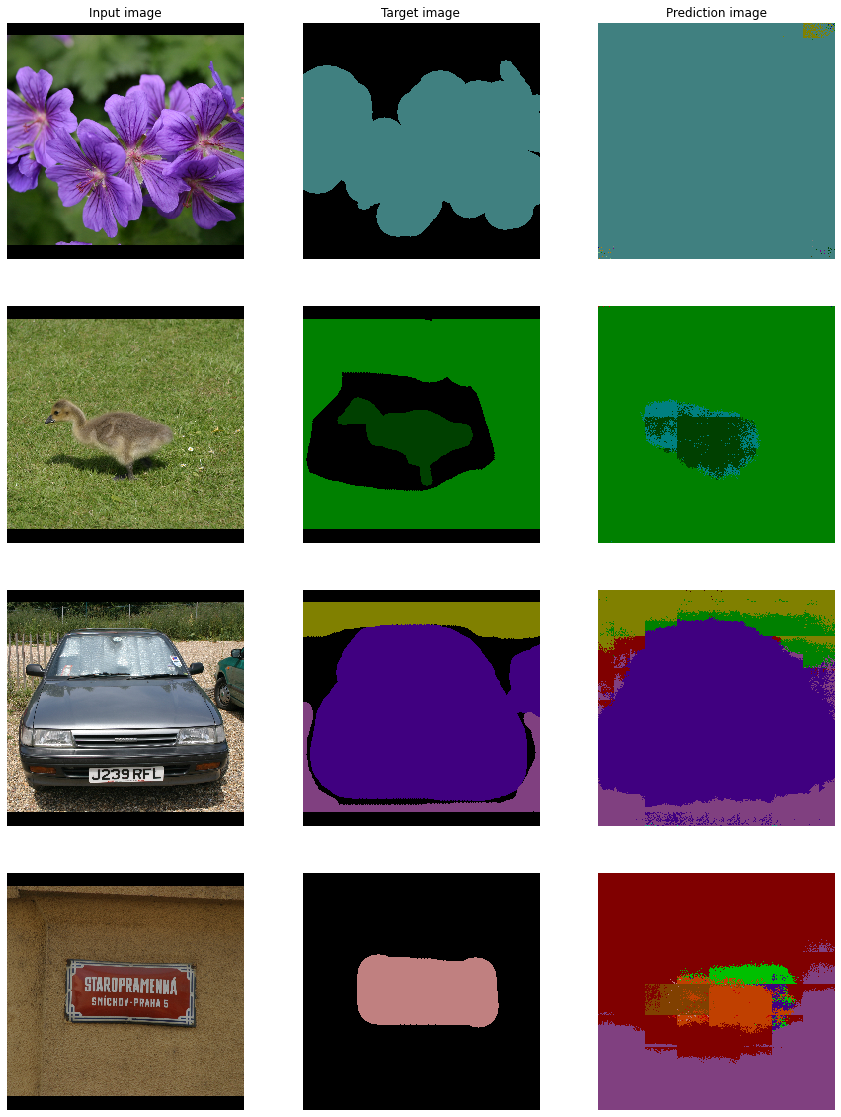

In [ ]:
num_example_imgs = 4
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, target) in enumerate(test_data[:num_example_imgs]):
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)
    if model.is_cuda:
        inputs = inputs.cuda()
    
    ## TODO: Retrieve the predictions.
    pred = torch.argmax(model(inputs), axis=1).cpu().numpy()
    img = img.numpy()
    target = target.numpy()

    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.transpose(1,2,0))
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(target))
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(pred))
    if i == 0:
        plt.title("Prediction image")
    
plt.show()

## Part 4: Visualize Filter Weights
You can visualize the convolutional filters of the very first layer. Each kernel provides the structures of edges, corners and circles. 


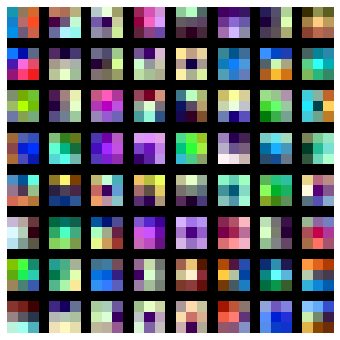

In [ ]:
from vis_utils import visualize_grid

# TODO: get the first (next) convolutional parameter 
conv_params = model.pretrained_model.features[0].weight.detach().cpu().numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()

# C) Object Detection to Instance Segmentation: Faster R-CNN to Mask R-CNN

You have learnt about **Faster R-CNN** [12]  when object detection was covered. Remember that Faster R-CNN [12] predicts bounding boxes and class scores for potential objects in the image.

**Mask R-CNN** [6] adds an extra branch into Faster R-CNN [12], which also predicts segmentation masks for each instance.

<img src="https://pythonawesome.com/content/images/2018/07/Mask-RCNN.png" alt="Mask R-CNN" width="500">

You will implement this extra branch, train the model, test it, and visualize the results. You will use PennFudan [7] dataset. 

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-hbreqb1b
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-hbreqb1b
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263916 sha256=fa4381d4492727fa9dd0a1ecaaf5bb93fc10bf140da8749c003883a21a89b934
  Stored in directory: /tmp/pip-ephem-wheel-cache-2u7gg0y6/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [ ]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2021-05-23 19:49:38--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  31.4MB/s    in 1.6s    

2021-05-23 19:49:40 (31.4 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2021-05-23 19:49:40--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-05-23 19:49:40--
Total wall clock time: 1.9s
Downloaded: 1 files, 51M in 1.6s (31.4 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

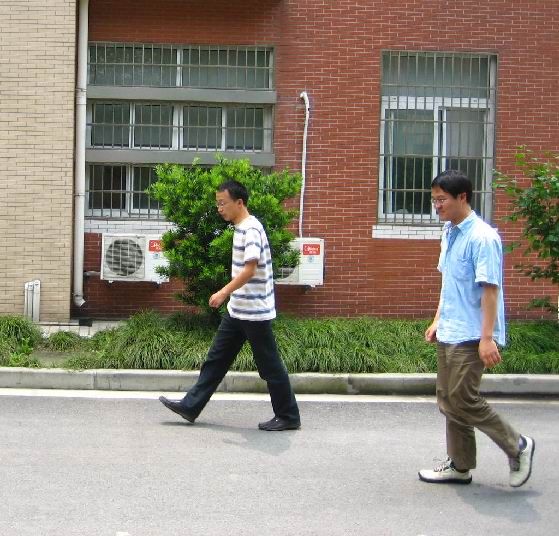

In [ ]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

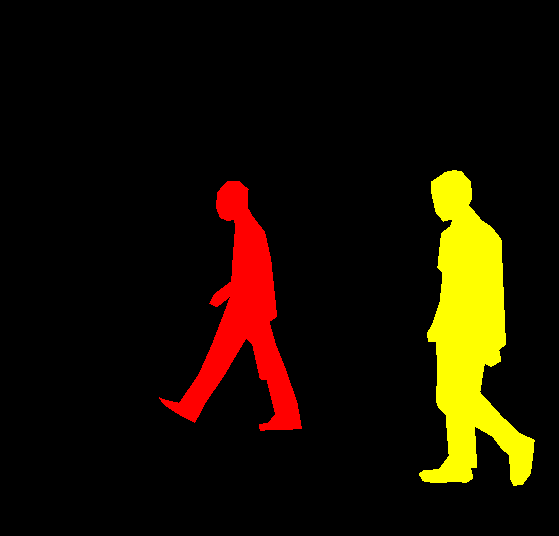

In [ ]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's add a color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

You can find how dataset for PennFudan [7] looks like below.
## Question 1
Given masks in an image in the dataset, find the bounding box coordinates of a mask.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            ##################################################################
            ###                      YOUR CODE STARTS                      ###
            ##################################################################
            # TODO: Given the masks, find the bounding box coordinate for each 
            # image and append to 'boxes'. See [8] for how bounding box
            # coordinates are represented.
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            ##################################################################
            ###                       YOUR CODE ENDS                       ###
            ##################################################################

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 25717, done.
remote: Counting objects: 100% (3188/3188), done.
remote: Compressing objects: 100% (816/816), done.
remote: Total 25717 (delta 2392), reused 3016 (delta 2312), pack-reused 22529
Receiving objects: 100% (25717/25717), 34.86 MiB | 28.62 MiB/s, done.
Resolving deltas: 100% (19079/19079), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


## Question 2
Implement transformations for images. (Keeping in mind our task and dataset, use appropriate data augmentations)

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

##################################################################
###                      YOUR CODE STARTS                      ###
##################################################################
# TODO: train_transform should convert image into a PyTorch tensor, then apply
# at least one two transformation for data augmentation
def train_transform():
    transforms = [T.ToTensor(), T.RandomHorizontalFlip(0.5)]
    return T.Compose(transforms)

# TODO: test_transform should convert image into a PyTorch tensor
def test_transform():
    transforms = [T.ToTensor()]
    return T.Compose(transforms)
##################################################################
###                       YOUR CODE ENDS                       ###
##################################################################

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', train_transform())
dataset_test = PennFudanDataset('PennFudanPed', test_transform())

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Question 3
<img src="https://vipulvaibhaw.files.wordpress.com/2019/04/screenshot-2019-04-20-at-8.34.16-am.png?w=1100" alt="Mask R-CNN detailed" width="500">

Mask R-CNN [6] proposes two heads for mask detection. We have implemented below the one on the right (w/ FPN) on top of a pretrained Faster R-CNN [12]. You can find Figure 4 in [6] for the details of the network.

In [ ]:
import torchvision
from torch import nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

fasterrcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

#Defining ROI Align. 
mask_roi_pool = torchvision.ops.MultiScaleRoIAlign(
                featmap_names=['0', '1', '2', '3'],
                output_size=14,
                sampling_ratio=2)

#Adding head
mask_head = nn.Sequential(
          nn.Conv2d(256, 256, (3,3), (1,1), (1,1)),
          nn.ReLU(True),
          nn.Conv2d(256, 256, (3,3), (1,1), (1,1)),
          nn.ReLU(True),
          nn.Conv2d(256, 256, (3,3), (1,1), (1,1)),
          nn.ReLU(True),
          nn.Conv2d(256, 256, (3,3), (1,1), (1,1)),
          nn.ReLU(True),
        )

#Adding predictor
mask_predictor = nn.Sequential(
          nn.ConvTranspose2d(256, 256, 2, 2, 0),
          nn.ReLU(inplace=True),
          nn.Conv2d(256, 91, 1, 1, 0)
        )


my_mask = fasterrcnn
my_mask.roi_heads.mask_roi_pool = mask_roi_pool
my_mask.roi_heads.mask_head = mask_head
my_mask.roi_heads.mask_predictor = mask_predictor

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = my_mask
# move model to the right device
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Construct an optimizer.

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
##################################################################
###                      YOUR CODE STARTS                      ###
##################################################################
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
##################################################################
###                       YOUR CODE ENDS                       ###
##################################################################

In [ ]:
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 25 epochs
num_epochs = 25

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/60]  eta: 0:01:00  lr: 0.000090  loss: 0.8976 (0.8976)  loss_classifier: 0.1262 (0.1262)  loss_box_reg: 0.0566 (0.0566)  loss_mask: 0.6938 (0.6938)  loss_objectness: 0.0165 (0.0165)  loss_rpn_box_reg: 0.0044 (0.0044)  time: 1.0108  data: 0.4679  max mem: 10282
Epoch: [0]  [10/60]  eta: 0:00:20  lr: 0.000936  loss: 0.9019 (0.9184)  loss_classifier: 0.1209 (0.1356)  loss_box_reg: 0.0681 (0.0638)  loss_mask: 0.6933 (0.6932)  loss_objectness: 0.0195 (0.0198)  loss_rpn_box_reg: 0.0051 (0.0060)  time: 0.4088  data: 0.0466  max mem: 10282
Epoch: [0]  [20/60]  eta: 0:00:15  lr: 0.001783  loss: 0.8635 (0.8849)  loss_classifier: 0.0919 (0.1019)  loss_box_reg: 0.0557 (0.0691)  loss_mask: 0.6932 (0.6933)  loss_objectness: 0.0065 (0.0148)  loss_rpn_box_reg: 0.0051 (0.0057)  time: 0.3656  data: 0.0060  max mem: 10282
Epoch: [0]  [30/60]  eta: 0:00:11  lr: 0.002629  loss: 0.8049 (0.8626)  loss_classifier: 0.0442 (0.0826)  loss_box_reg: 0.0495 (0.0694)  loss_mask: 0.6932 (0.6933)  loss

In [ ]:
# pick one image from the test set
img, _ = dataset_test[4]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

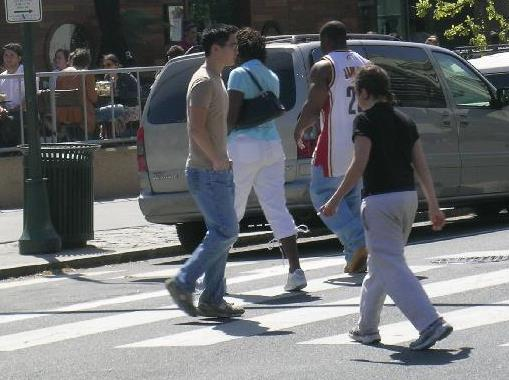

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

## Question 4
Given mask of an object, colorize the mask. 

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings

"""
Given a mask for an object, return coloured mask. Shape of the given mask is
(H, W), so the shape of returned mask should be (3, H, W).
"""
def get_coloured_mask(mask):
    ##################################################################
    ###                      YOUR CODE STARTS                      ###
    ##################################################################

    # TODO: Assign a color to the given mask. Bonus: assign distinct colors to
    # each masks

    # TODO: Masks you receive might contain noise, so apply a threshold.
    mask[mask < 10] = 0
    random_colors = np.random.rand(3, 1, 1)
    coloured_mask = (random_colors * mask).astype(np.uint8)
    ##################################################################
    ###                       YOUR CODE ENDS                       ###
    ##################################################################
    
    return coloured_mask

## Question 5
Visualize the image, masks, and bounding boxes. You can expect non-perfect masks.  

Optional: If you want better masks, change your training strategy! (changing # of epochs, different optimizer etc.)

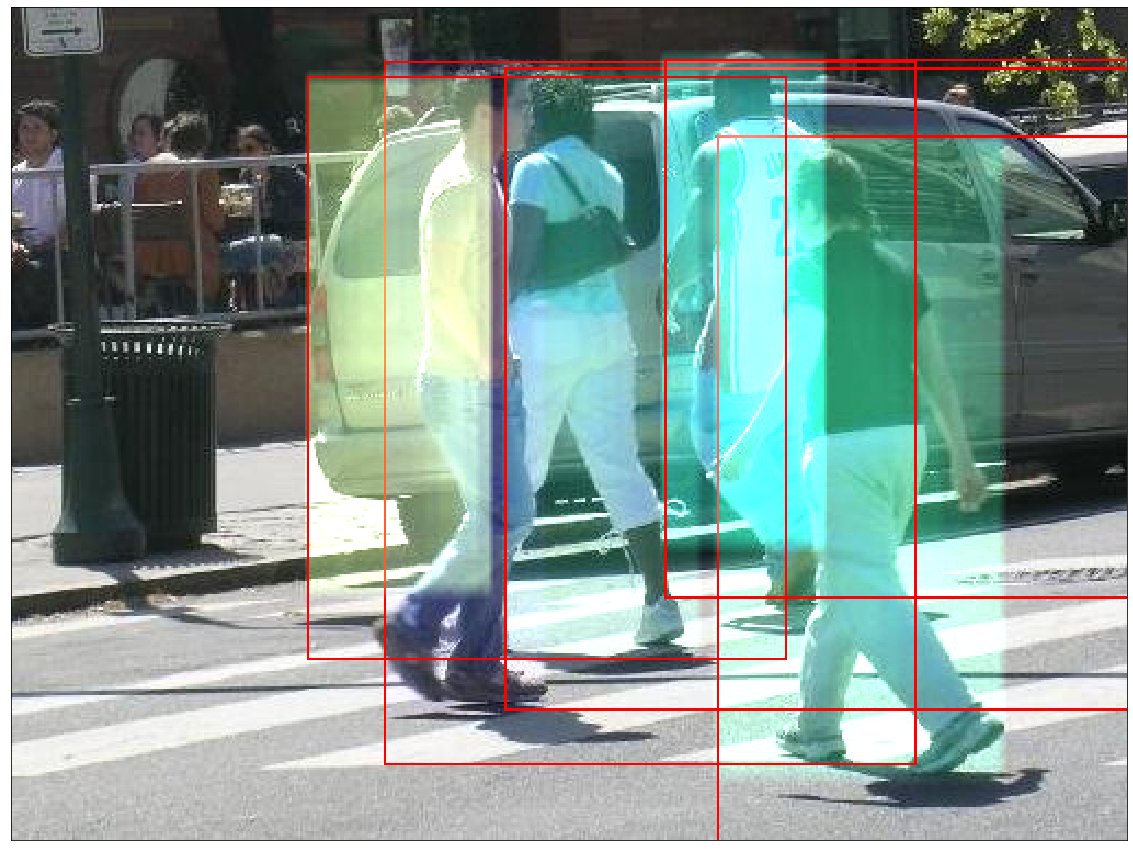

In [ ]:
%matplotlib inline

def vis_instance(img):
    img = img.mul(255).permute(1, 2, 0).byte().numpy()
    scores = prediction[0]['scores'].tolist()
    for i in range(len(scores)):
      box = prediction[0]['boxes'][i].cpu().numpy()
      mask = prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
      rgb_mask = get_coloured_mask(mask)
      ##################################################################
      ###                      YOUR CODE STARTS                      ###
      ##################################################################
      # TODO: Add image and RGB mask on top of each other. Hint: check cv2
      # operations (cv2.addWeighted)
      rgb_mask = rgb_mask.transpose(1, 2, 0)
      img = cv2.addWeighted(img, 1.0 ,rgb_mask, 1, 0)

      # TODO: Add a rectangle around the instances. Hint: check cv2 drawing
      # functions (cv2.rectangle)
      img = cv2.rectangle(img, box, color=(255, 0, 0))
      ##################################################################
      ###                       YOUR CODE ENDS                       ###
      ##################################################################
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

vis_instance(img)

# References

[1] J. Long, E. Shelhamer, and T. Darrell. Fully Convolutional Networks for Semantic Segmentation. CVPR, 2015.

[2] V. Badrinarayanan, A. Kendall, and R. Cipolla. Fully Convolutional Networks for Semantic Segmentation. PAMI, 2017.

[3] O. Ronneberger, P. Fischer, and T. Brox. U-Net: Convolutional Networks for Biomedical Image Segmentation. MICCAI, 2015.

[4] Checkerboard artifacts [https://distill.pub/2016/deconv-checkerboard/]

[5] A survey of loss functions for semantic segmentation [https://arxiv.org/pdf/2006.14822.pdf].

[6] K. He, G. Gkioxari, P. Dollar, and R. Girshick. Mask R-CNN. ICCV, 2017.   

[7] https://www.cis.upenn.edu/~jshi/ped_html/  

[8] J. Dai, K. He, and J. Sun. Instance-aware Semantic Segmentation via Multi-task Network Cascades. CVPR, 2016.  

[9] R. Girshick. Fast R-CNN. ICCV, 2015.   

[10] J. Long, E. Shelhamer, and T. Darrell. Fully convolutional networks for semantic segmentation. CVPR, 2015.   

[11] D. Bolya, C. Zhou, F. Xiao, Y. Jae Lee. YOLACT: Real-time Instance Segmentation. ICCV, 2019 

[12] Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks. S. Ren, K. He, R. Girshick, J. Sun. NIPS, 2015    

[13] https://d2l.ai/chapter_computer-vision/bounding-box.html#bounding-box